In [1]:
import os
os.getpid()

883

In [2]:
from IPython.display import Image

import matplotlib_options
matplotlib_options.define_matplotlib_backend_options(backend='agg')

%matplotlib inline
# Use autoreload to keep up-to-date version of custom packages
# %load_ext autoreload
import mwTools
import cterminal
# %autoreload 2

import matplotlib.pyplot as plt
from cterminal import colorBackground1, get_line_width, vmax, cmap, colorHeatmapLine
from matplotlib.font_manager import FontProperties
from matplotlib.patches import Rectangle
from matplotlib import gridspec
from matplotlib import colors
import seaborn as sns
sns.set_style('whitegrid')

import numpy as np
from numpy import exp, log2, log10, log
import pandas as pd
idx = pd.IndexSlice
import collections
from collections import Counter
import json
import argparse
import subprocess
import shlex
import itertools
import os.path
import re
import gzip
import urllib
import gc
import time
from pathlib import Path
import random
import math

import Bio
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation, ExactPosition
from Bio.SeqRecord import SeqRecord

from importlib import reload
import mwTools.bio
reload(mwTools.bio)
from mwTools.bio import sort_codon_index
from mwTools.bio import convert_df_to_fasta
from statannot import add_stat_annotation
from mwTools.id import *
from mwTools.paths import p
from cterminal import *

p = p()
print(p.rootPath)

/users/lserrano/mweber


In [35]:
from matplotlib_options import set_fontsize_paper, set_fontsize_screen

In [3]:
rootPath = p.rootPath
cterminalPath = p.cterminalPath
refSeqPath = p.refSeqPath
mycoplasmaDataPath = p.mycoplasmaDataPath
mpnAnnotationPath = p.mpnAnnotationPath
analysisCtermDataPath = p.analysisCtermDataPath
analysisCtermPlotsPath = p.analysisCtermPlotsPath
analysisCtermPath = p.analysisCtermPath
ctermELISAPath = p.ctermELISAPath
ctermELMseqPath = p.ctermELMseqPath
ctermAmiGOPath = analysisCtermPath / 'AmiGO'
analysisAbundancePath = p.analysisAbundancePath
taxonomyPath = p.taxonomyPath

importExistingDataframe = True

### import data

In [19]:
degradationPath = p.cterminalPath / 'data' / 'degradation_assay'
outputPath = degradationPath

In [341]:
lucDf = pd.read_excel(degradationPath / 'degradation_experiment_luciferase_raw_data.xlsx', header=[0,1],
                      index_col=[0,1])
lucDf = lucDf.rename(columns={'0h':0, '2h':2, '4h':4, '6h':6, '8h':8})
lucDf.columns.names = ['observable', 'time']
lucDf.index.names = ['C-terminal amino acid(s)', 'replicate']
lucDf.head()

observable                         Luc expression                              \
time                                            0         2        4        6   
C-terminal amino acid(s) replicate                                              
K                        1                82086.5   76125.5  72334.0  64825.0   
D                        1                96850.0  105319.0  92399.5  86481.5   
L                        1                17821.0   18063.5  12958.5   8447.0   
F                        1                43728.0   49739.5  41444.0  34429.5   
P                        1                54331.5   56255.5  46749.5  36679.5   

observable                                  CAT expression  
time                                      8              0  
C-terminal amino acid(s) replicate                          
K                        1          46068.5    2284.691381  
D                        1          76587.5    2485.185217  
L                        1           4989.5    1156.888902  
F                        1          25310.0    2496.049451  
P                        1          27078.0    2475.555461

### normalizing by the CAT expression at time 0h

In [342]:
lucDf2 = lucDf
df = lucDf2.loc[:, 'Luc expression']
lucDf2 = pd.concat([df[col] / lucDf2[('CAT expression', 0)] for col in df.columns], axis=1)
lucDf2.columns = df.columns
lucDf2.head()

/home/mweber/.local/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:93: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if a.name == b.name:


,time,0,2,4,6,8
C-terminal amino acid(s),replicate,,,,,
K,1,35.928923,33.319818,31.660294,28.373635,20.163993
D,1,38.970938,42.378733,37.180126,34.798815,30.817623
L,1,15.404245,15.613859,11.201162,7.301479,4.312860
F,1,17.518884,19.927289,16.603838,13.793597,10.140023
P,1,21.947196,22.724395,18.884449,14.816675,10.938151


In [343]:
aaRef = 'P'
df = lucDf2.copy()
ref = df.loc[aaRef, 0]
ref.name = '{}_0'.format(aaRef)
df = df.join(ref)
df = pd.concat([df[col] / df['{}_0'.format(aaRef)] for col in df.columns[:-1]], axis=1)
df.columns = lucDf2.columns
lucDf3 = df
lucDf3

,time,0,2,4,6,8
C-terminal amino acid(s),replicate,,,,,
K,1,1.637062,1.518181,1.442567,1.292814,0.918750
D,1,1.775668,1.930941,1.694072,1.585570,1.404171
L,1,0.701878,0.711428,0.510369,0.332684,0.196511
F,1,0.798229,0.907965,0.756536,0.628490,0.462019
P,1,1.000000,1.035412,0.860449,0.675106,0.498385
T,1,1.117811,1.209354,0.944838,0.792113,0.569722
WL,1,0.399086,0.418433,0.320239,0.234460,0.180213
NK,1,1.505090,1.373785,1.195211,1.086081,0.841817
K,2,1.235648,1.279214,0.980155,0.713075,0.586310


In [344]:
ylabel = 'normalized luminescence\nrelative to C-term {} at time=0'.format(aaRef)
xlabel = 'time (h)'

In [345]:
plotDf = lucDf3.stack().reset_index()
plotDf = plotDf.rename(columns={0:ylabel, 'time':xlabel})
plotDf.head(10)

,C-terminal amino acid(s),replicate,time (h),normalized luminescence relative to C-term P at time=0
0,K,1,0,1.637062
1,K,1,2,1.518181
2,K,1,4,1.442567
3,K,1,6,1.292814
4,K,1,8,0.918750
5,D,1,0,1.775668
6,D,1,2,1.930941
7,D,1,4,1.694072
8,D,1,6,1.585570
9,D,1,8,1.404171


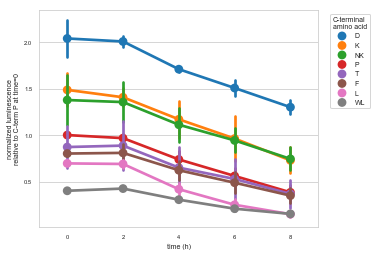

In [346]:
fig, ax = plt.subplots(figsize=(5,4))
sns.pointplot(data=plotDf, x=xlabel, y=ylabel, units='replicate', hue='C-terminal amino acid(s)',
              hue_order=aaOrder, ci="sd")
ax.legend(bbox_to_anchor=(1.03, 1.0), loc='upper left', title='C-terminal\namino acid')
fig.savefig(outputPath / 'time_luc_norm_{}0.svg'.format(aaRef))

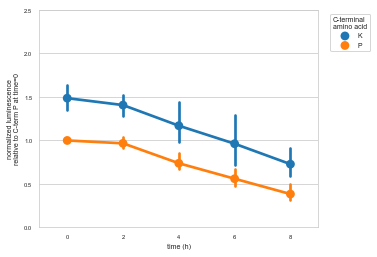

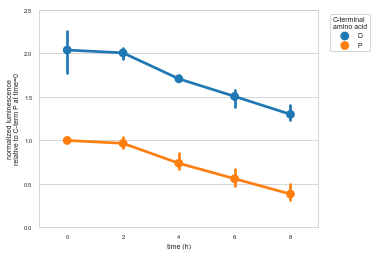

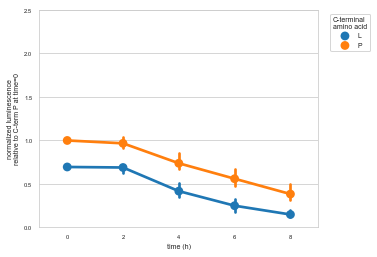

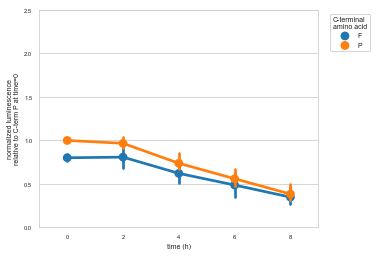

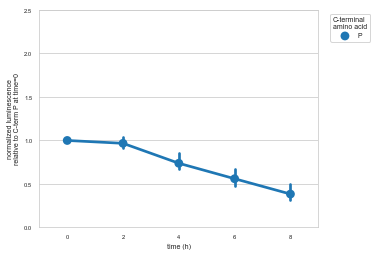

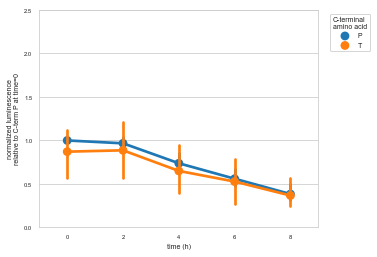

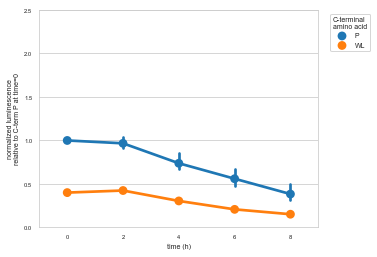

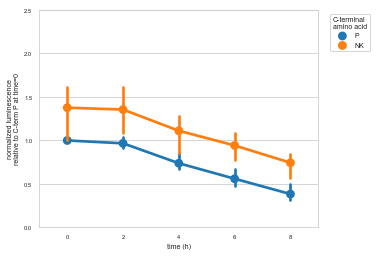

In [347]:
for aa in ['K', 'D', 'L', 'F', 'P', 'T', 'WL', 'NK']:
    fig, ax = plt.subplots(figsize=(5,4))
    sns.pointplot(data=plotDf[plotDf['C-terminal amino acid(s)'].map(lambda x: x in ['P', aa])], x=xlabel, y=ylabel, units='replicate', hue='C-terminal amino acid(s)')
    ax.legend(bbox_to_anchor=(1.03, 1.0), loc='upper left', title='C-terminal\namino acid')
    ax.set_ylim(0, 2.5)
    fig.savefig(outputPath / 'time_luc_norm_{}0_aa_{}.svg'.format(aaRef, aa))

In [348]:
ylabel = 'normalized luminescence at time=0\nrelative to C-term {}'.format(aaRef)
ylabel = 'steady-state (time=0)\nnormalized luminescence'
xlabel = 'time (h)'
plotDf.columns = list(plotDf.columns[:-1]) + [ylabel]

In [349]:
plotDf2 = plotDf[plotDf['time (h)'] == 0]

In [350]:
lucTime0 = plotDf2

In [351]:
plotDf2

,C-terminal amino acid(s),replicate,time (h),steady-state (time=0) normalized luminescence
0,K,1,0,1.637062
5,D,1,0,1.775668
10,L,1,0,0.701878
15,F,1,0,0.798229
20,P,1,0,1.000000
25,T,1,0,1.117811
30,WL,1,0,0.399086
35,NK,1,0,1.505090
40,K,2,0,1.235648
45,D,2,0,2.083347


In [352]:
aaOrder = ['D', 'K', 'NK', 'P', 'T', 'F', 'L', 'WL']

In [353]:
from statannot import stat_test
df = plotDf2.set_index(['C-terminal amino acid(s)', 'replicate'])

box_pairs = [('NK', 'F'), ('K', 'L'), ('D', 'WL')]

statList = []
for box_pair in box_pairs:
    pval, _, _ = stat_test(test='t-test_ind', box_data1=df.loc[box_pair[0], ylabel],
                           box_data2=df.loc[box_pair[1], ylabel])
    box_data1 = df.loc[box_pair[0], ylabel]
    box_data2 = df.loc[box_pair[1], ylabel]
    fold = box_data2.mean() / box_data1.mean()
    statList.append({'aa1':box_pair[0], 'aa2':box_pair[1], 'FC':fold, '1/FC':1/fold, 't-test_ind_pval':pval})
statDf = pd.DataFrame(statList)
statDf

,1/FC,FC,aa1,aa2,t-test_ind_pval
0,1.718661,0.581848,NK,F,0.037741
1,2.137972,0.467733,K,L,0.003339
2,5.090525,0.196443,D,WL,0.000327


In [354]:
data1 = df.loc[['K', 'D', 'NK']].iloc[:, 1]
data2 = df.loc[['F', 'L', 'WL']].iloc[:, 1]
stat_test(test='t-test_ind', box_data1=data1, box_data2=data2)

(2.6522949144799026e-06,
 't-test independent samples, P_val=2.652e-06 stat=7.070e+00',
 't-test_ind')

In [355]:
df3 = plotDf2.groupby('C-terminal amino acid(s)')[ylabel].mean()
df3

C-terminal amino acid(s)
D     2.039576
F     0.801224
K     1.486342
L     0.695211
NK    1.377033
P     1.000000
T     0.871206
WL    0.400661
Name: steady-state (time=0)\nnormalized luminescence, dtype: float64

In [356]:
df3.loc['D']/df3.loc['WL']

5.090525275750988

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

NK v.s. F: t-test independent samples, P_val=3.774e-02 stat=3.058e+00
K v.s. L: t-test independent samples, P_val=3.339e-03 stat=6.251e+00
D v.s. WL: t-test independent samples, P_val=3.267e-04 stat=1.150e+01


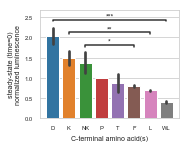

In [357]:
set_fontsize_paper()
fig, ax = plt.subplots(figsize=(2.5, 2))
x = 'C-terminal amino acid(s)'
sns.barplot(data=plotDf2, x=x, y=ylabel, order=aaOrder, ci="sd")
add_stat_annotation(ax=ax, plot='barplot', data=plotDf2, x=x, y=ylabel, order=aaOrder,
                    box_pairs=box_pairs,
                    test='t-test_ind', text_format='star', loc='inside')
fig.savefig(outputPath / 'initial_luc_norm_{}0.svg'.format(aaRef))
fig.savefig(outputPath / 'initial_luc_norm_{}0.png'.format(aaRef), dpi=300)

In [169]:
subFolder = 'nread_cutoff_30'

In [172]:
damDfAA = pd.read_csv(ctermELMseqPath / subFolder / 'damDfAA.csv', index_col=[0,1])
damDfAA.head()

DAMratio  log10DAMratio  position  log10DAMratio_norm
promoter amino acid                                                        
strong   *           11.889748       1.075173        -2            0.085194
         *           10.169228       1.007288        -1            0.017309
         *            9.715327       0.987457         1           -0.002522
         *            9.860408       0.993895         2            0.003916
         A            9.173361       0.962528        -2           -0.027451

In [173]:
damMeanDf = (damDfAA[damDfAA['position'] == -1].loc['weak'] + damDfAA[damDfAA['position'] == -1].loc['strong'])/2
damMeanDf.sort_values('log10DAMratio_norm')

,DAMratio,log10DAMratio,position,log10DAMratio_norm
amino acid,,,,
L,4.501914,0.455157,-1,-0.108770
C,4.536366,0.462535,-1,-0.101392
M,4.667488,0.474933,-1,-0.088994
I,4.838266,0.482121,-1,-0.081806
F,4.865018,0.493722,-1,-0.070205
V,5.104489,0.517267,-1,-0.046660
A,5.067569,0.518185,-1,-0.045742
W,5.054789,0.520666,-1,-0.043261
Y,5.455221,0.550106,-1,-0.013821


In [178]:
damDfAApair = pd.read_csv(ctermELMseqPath / subFolder / 'damDfAApair.csv', index_col=[0,1,2])
damDfAApair.head()

DAMratio  log10DAMratio  log10DAMratio_norm
promoter aa_-1 aa_-2                                              
strong   *     *      12.024960       1.080084            0.087005
               A       9.226308       0.965028           -0.028051
               C       7.970354       0.901478           -0.091602
               D      12.630268       1.101413            0.108333
               E      12.279936       1.089196            0.096117

In [180]:
damDfAApairMean = (damDfAApair.loc['weak'] + damDfAApair.loc['strong'])/2
damDfAApairMean.sort_values('log10DAMratio_norm').head()

,,DAMratio,log10DAMratio,log10DAMratio_norm
aa_-1,aa_-2,,,
L,W,2.599727,0.202173,-0.365957
M,W,2.839537,0.243393,-0.324737
C,W,2.969708,0.251643,-0.316487
A,W,2.856135,0.261892,-0.306238
F,W,2.873198,0.266787,-0.301343


In [184]:
damDfAApairMean2 = damDfAApairMean.loc[[('L', 'W'), ('K', 'N')]]
damDfAApairMean2.index = ['WL', 'NK']
damDfAApairMean2

,DAMratio,log10DAMratio,log10DAMratio_norm
WL,2.599727,0.202173,-0.365957
NK,9.259017,0.792999,0.224869


In [186]:
damMeanDf = pd.concat([damMeanDf, damDfAApairMean2])
damMeanDf

/home/mweber/.local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


,DAMratio,log10DAMratio,log10DAMratio_norm,position
*,5.777114,0.574369,0.010442,-1.0
A,5.067569,0.518185,-0.045742,-1.0
C,4.536366,0.462535,-0.101392,-1.0
D,6.788950,0.659304,0.095377,-1.0
E,6.916287,0.662206,0.098279,-1.0
F,4.865018,0.493722,-0.070205,-1.0
G,5.987397,0.601112,0.037185,-1.0
H,6.105979,0.615276,0.051349,-1.0
I,4.838266,0.482121,-0.081806,-1.0
K,7.498019,0.710537,0.146610,-1.0


In [202]:
plotDf3 = df3.to_frame()
plotDf3 = plotDf3.join(damMeanDf['DAMratio']).reset_index()
plotDf3

,C-terminal amino acid(s),normalized luminescence at time=0 relative to C-term P,DAMratio
0,D,2.039576,6.788950
1,F,0.801224,4.865018
2,K,1.486342,7.498019
3,L,0.695211,4.501914
4,NK,1.377033,9.259017
5,P,1.000000,5.397646
6,T,0.871206,6.016893
7,WL,0.400661,2.599727


In [200]:
xlabel

'normalized luminescence at time=0\nrelative to C-term P'

In [201]:
ylabel

'DAMratio'

0.7528177406343661


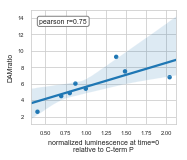

In [205]:
set_fontsize_paper()
fig, ax = plt.subplots(figsize=(2.5, 2))
xlabel = 'normalized luminescence at time=0\nrelative to C-term {}'.format(aaRef)
ylabel = 'DAMratio'

pearson = plotDf3[[xlabel, ylabel]].corr().iloc[0, 1]
print(pearson)
ax.annotate('pearson r={:.2f}'.format(pearson), xy=(0.06, 0.93),
            xycoords='axes fraction', ha='left', va='top', fontsize='medium',
            bbox=dict(boxstyle="round", fc='1', ec='0.5'),)
plt.tight_layout()
sns.regplot(ax=ax, data=plotDf3, x=xlabel, y=ylabel, ci=95, n_boot=1000, fit_reg=True,
            scatter_kws=dict(alpha=1, s=20, edgecolors='none'))
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)


filename = 'initial_luc_norm_{}0_corr_ELMseq'.format(aaRef)
fig.savefig(outputPath / (filename + '.svg'))
fig.savefig(outputPath / (filename + '.png'), dpi=300, bbox_inches='tight')

### normalizing by the Luc expression at time 0h

We normalize each individual replicate by its Luc expression a time 0.

In [207]:
lucDf3.head()

,time,0,2,4,6,8
C-terminal amino acid(s),replicate,,,,,
K,1,1.637062,1.518181,1.442567,1.292814,0.918750
D,1,1.775668,1.930941,1.694072,1.585570,1.404171
L,1,0.701878,0.711428,0.510369,0.332684,0.196511
F,1,0.798229,0.907965,0.756536,0.628490,0.462019
P,1,1.000000,1.035412,0.860449,0.675106,0.498385


In [208]:
df = lucDf3.copy()
df = pd.concat([df[col] / df[0] for col in df.columns], axis=1)
df.columns = lucDf3.columns
lucDf4 = df
lucDf4.head()

,time,0,2,4,6,8
C-terminal amino acid(s),replicate,,,,,
K,1,1.0,0.927381,0.881192,0.789716,0.561219
D,1,1.0,1.087445,0.954047,0.892943,0.790785
L,1,1.0,1.013608,0.727148,0.473991,0.279979
F,1,1.0,1.137475,0.947768,0.787356,0.578805
P,1,1.0,1.035412,0.860449,0.675106,0.498385


melt the dataframe

In [209]:
ylabel = 'luminescence relative to time=0'
xlabel = 'time (h)'

In [210]:
plotDf = lucDf4.stack().reset_index()
plotDf = plotDf.rename(columns={0:ylabel, 'time':xlabel})
plotDf.head(10)

,C-terminal amino acid(s),replicate,time (h),luminescence relative to time=0
0,K,1,0,1.000000
1,K,1,2,0.927381
2,K,1,4,0.881192
3,K,1,6,0.789716
4,K,1,8,0.561219
5,D,1,0,1.000000
6,D,1,2,1.087445
7,D,1,4,0.954047
8,D,1,6,0.892943
9,D,1,8,0.790785


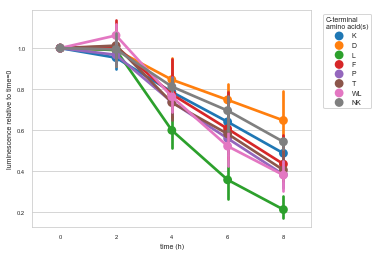

In [95]:
fig, ax = plt.subplots(figsize=(5,4))
sns.pointplot(ax=ax, data=plotDf, x=xlabel, y=ylabel, units='replicate', hue='C-terminal amino acid(s)')
ax.legend(bbox_to_anchor=(1.03, 1.0), loc='upper left', title='C-terminal\namino acid(s)')
fig.savefig(outputPath / 'time_luc_norm_time0.svg')

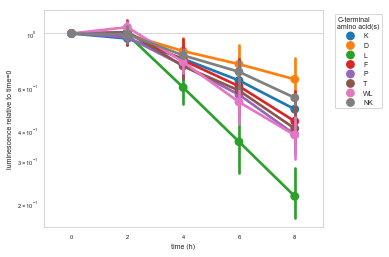

In [96]:
fig, ax = plt.subplots(figsize=(5,4))
sns.pointplot(ax=ax, data=plotDf, x=xlabel, y=ylabel, units='replicate', hue='C-terminal amino acid(s)')
ax.legend(bbox_to_anchor=(1.03, 1.0), loc='upper left', title='C-terminal\namino acid(s)')
plt.yscale('log')
fig.savefig(outputPath / 'time_luc_norm_time0_log.svg')

#### exponential fit

In [211]:
import statsmodels.api as sm

In [212]:
logDf = np.log(lucDf4.iloc[:, 1:].T)
logDf

C-terminal amino acid(s),K,D,L,F,P,T,WL,NK,K,D,...,WL,NK,K,D,L,F,P,T,WL,NK
replicate,1,1,1,1,1,1,1,1,2,2,...,2,2,3,3,3,3,3,3,3,3
time,,,,,,,,,,,,,,,,,,,,,
2,-0.075390,0.083830,0.013516,0.128811,0.034800,0.078714,0.047342,-0.091284,0.034651,-0.029255,...,0.019722,-0.004316,-0.108421,-0.088906,0.026701,-0.012197,-0.084507,-0.053765,0.110554,0.069709
4,-0.126479,-0.047042,-0.318626,-0.053646,-0.150301,-0.168114,-0.220108,-0.230530,-0.231640,-0.175213,...,-0.371149,-0.233968,-0.378719,-0.294002,-0.581913,-0.334016,-0.396391,-0.433317,-0.226665,-0.159976
6,-0.236082,-0.113233,-0.746566,-0.239075,-0.392886,-0.344423,-0.531891,-0.326277,-0.549764,-0.406657,...,-0.856558,-0.513708,-0.587421,-0.378991,-1.096511,-0.556859,-0.646477,-0.586461,-0.588429,-0.265319
8,-0.577644,-0.234730,-1.273042,-0.546789,-0.696383,-0.673979,-0.795039,-0.581046,-0.745501,-0.503670,...,-1.192231,-0.678327,-0.849689,-0.601814,-1.680190,-0.982168,-1.146527,-1.026904,-0.942350,-0.572695


In [64]:
def exponential_decay_fit(s):
    print(s.name)
    aa, rep = s.name
    print("###", aa, "rep", rep)

    xdata = s.index
    ydata = s.values

    verbose = 2
    # Fitting the data with linear regression, no bounds on parameters,
    # using statsmodel least squares
    weights = None
    sigmaWeighted = False

    xdata = sm.add_constant(xdata)
    result = sm.OLS(ydata, xdata).fit()
    if verbose >= 2:
        print((result.params, result.rsquared))
        print(result.pvalues[1])
        print(result.summary())
        print(result.bse)

    paramD = result.params[1]
    paramIntercept = result.params[0]
    stdDevD = result.bse[1]
    stdDevIntercept = result.bse[0]
    covMatrix = result.cov_params()
    r_squared = result.rsquared
    
    return {'rate':paramD, 'intercept':paramIntercept, 'rate_std':stdDevD, 'intercept_std':stdDevIntercept,
            'R-squared':r_squared}

fitDf = logDf.iloc[:, :].apply(exponential_decay_fit, axis=0)

('K', 1)
### K rep 1
(array([ 0.15019216, -0.08081823]), 0.8525232796836663)
0.0766781277995921
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     11.56
Date:                Sat, 25 Jan 2020   Prob (F-statistic):             0.0767
Time:                        18:19:39   Log-Likelihood:                 4.6766
No. Observations:                   4   AIC:                            -5.353
Df Residuals:                       2   BIC:                            -6.581
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

/home/mweber/.local/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)
/home/mweber/.local/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)
/home/mweber/.local/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)
/home/mweber/.local/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)
/home/mweber/.local/anaconda3/lib/python3.6/site-packages/st

2
(array([ 0.43026281, -0.20606339]), 0.9956093753210563)
0.0021977273422071706
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     453.5
Date:                Sat, 25 Jan 2020   Prob (F-statistic):            0.00220
Time:                        18:19:39   Log-Likelihood:                 8.2714
No. Observations:                   4   AIC:                            -12.54
Df Residuals:                       2   BIC:                            -13.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

/home/mweber/.local/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)
/home/mweber/.local/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)
/home/mweber/.local/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)
/home/mweber/.local/anaconda3/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)
/home/mweber/.local/anaconda3/lib/python3.6/site-packages/st

In [65]:
fitDf = fitDf.T

In [213]:
fitDf

,,R-squared,intercept,intercept_std,rate,rate_std
C-terminal amino acid(s),replicate,,,,,
K,1,0.852523,0.150192,0.130186,-0.080818,0.023769
D,1,0.985991,0.177674,0.023587,-0.051094,0.004306
L,1,0.989832,0.490724,0.084151,-0.214381,0.015364
F,1,0.981414,0.375383,0.058954,-0.110611,0.010764
P,1,0.988326,0.307841,0.051271,-0.121807,0.009361
T,1,0.985976,0.331647,0.056222,-0.121720,0.010265
WL,1,0.998917,0.334807,0.018099,-0.141946,0.003304
NK,1,0.957865,0.083974,0.063564,-0.078252,0.011605
K,2,0.992245,0.291581,0.045514,-0.132929,0.008310


0 0 0
1 0 1
2 0 2
3 1 0
4 1 1
5 1 2
6 2 0
7 2 1


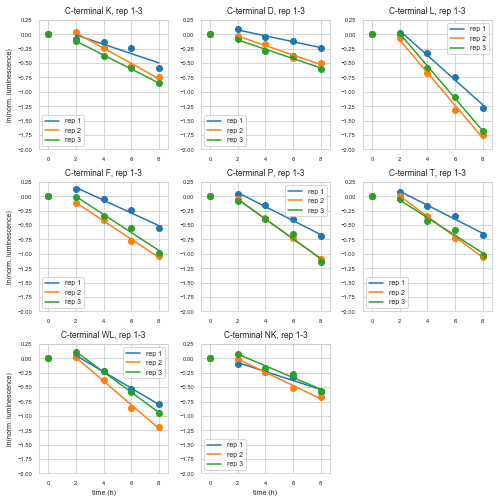

In [231]:
lucDfLog = np.log(lucDf4).T
fig, axes = plt.subplots(3, 3, figsize=(7, 7))
for k, aa in enumerate(fitDf.index.get_level_values(0).unique()):
#     fig, ax = plt.subplots()
    i, j = k // 3, k % 3
    print(k, i, j)
    ax = axes[i, j]
    for rep in range(1, 4):
        data = lucDfLog[(aa, rep)]
        ax.scatter(data.index, data.values)
        d = fitDf.loc[(aa, rep), 'rate']
        d0 = fitDf.loc[(aa, rep), 'intercept']
        ax.plot([2, 8], [d0 + d*2, d0 + d*8], label='rep {:d}'.format(rep))
    ax.legend()
    ax.set_ylim(-2, 0.25)
    ax.set_title('C-terminal {}, rep 1-3'.format(aa))
    if i == 2:
        ax.set_xlabel('time (h)')
    if j == 0:
        ax.set_ylabel('ln(norm. luminescence)')
axes[2, 2].axis('off')
fig.tight_layout()
filename = 'time_luc_norm_time0_logfit'
fig.savefig(outputPath / (filename + '.svg'))
fig.savefig(outputPath / (filename + '.png'), dpi=300, bbox_inches='tight')

In [234]:
fitDf.loc['L']

,R-squared,intercept,intercept_std,rate,rate_std
replicate,,,,,
1,0.989832,0.490724,0.084151,-0.214381,0.015364
2,0.993069,0.467016,0.091756,-0.283588,0.016752
3,0.999065,0.575839,0.033378,-0.281763,0.006094


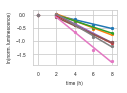

In [235]:
lucDfLog = np.log(lucDf4).T

fig, ax = plt.subplots(figsize=(1.5, 1))

for aa in aaOrder:
    rep = 2
    data = lucDfLog[(aa, rep)]
    ax.scatter(data.index, data.values, s=5)
    d = fitDf.loc[(aa, rep), 'rate']
    d0 = fitDf.loc[(aa, rep), 'intercept']
    ax.plot([2, 8], [d0 + d*2, d0 + d*8], label='rep {:d}'.format(rep))
# ax.legend(bbox_to_anchor=(1.03, 1.0), loc='upper left', title='C-terminal\namino acid(s)')
ax.tick_params(axis='both', labelsize='x-small')
ax.xaxis.label.set_size('x-small')
ax.yaxis.label.set_size('x-small')
ax.set_xlabel('time (h)')
ax.set_ylabel('ln(norm. luminescence)')
fig.savefig(outputPath / 'time_luc_norm_time0_logfit_rep{}.svg'.format(rep))

In [236]:
data

time
0    0.000000
2    0.019722
4   -0.371149
6   -0.856558
8   -1.192231
Name: (WL, 2), dtype: float64

In [237]:
# stat = data.groupby(xlabel)[ylabel].describe().loc[aaOrder]
# y = stat['mean']
# yerr = stat['std']
# x = np.arange(0, len(aaOrder))
# x

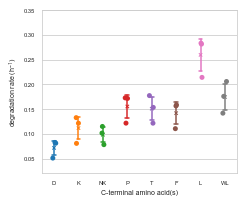

In [238]:
fig, ax = plt.subplots(figsize=(3.5, 3))

xlabel = 'C-terminal amino acid(s)'
ylabel = 'degradation rate (h$^{-1}$)'
data = fitDf.reset_index().rename(columns={'rate':ylabel, 'C-terminal amino acid(s)':xlabel})
data[ylabel] = - data[ylabel]
sns.stripplot(ax=ax, data=data, x=xlabel, y=ylabel, order=aaOrder)
sns.pointplot(ax=ax, data=data, x=xlabel, y=ylabel, order=aaOrder,
              join=False, ci="sd", palette=sns.color_palette(), errwidth=1.5, capsize=0.15, scale=0.5,
              markers='x')

# ax.errorbar(x, y, yerr=yerr, ls='none', capsize=0.15)

box_pairs = [('D', 'P'), ('K', 'P'), ('NK', 'P'), ('P', 'F'), ('P', 'L'), ('P', 'WL')]
# add_stat_annotation(ax=ax, plot='barplot', data=data, x=xlabel, y=ylabel, order=aaOrder,
#                     box_pairs=box_pairs,
#                     test='t-test_ind', text_format='star', loc='outside')
ax.set_ylim(0.02, 0.35)
fig.savefig(outputPath / 'time_luc_norm_time0_logfit_degradation_rates.svg')

In [239]:
data

,C-terminal amino acid(s),replicate,R-squared,intercept,intercept_std,degradation rate (h$^{-1}$),rate_std
0,K,1,0.852523,0.150192,0.130186,0.080818,0.023769
1,D,1,0.985991,0.177674,0.023587,0.051094,0.004306
2,L,1,0.989832,0.490724,0.084151,0.214381,0.015364
3,F,1,0.981414,0.375383,0.058954,0.110611,0.010764
4,P,1,0.988326,0.307841,0.051271,0.121807,0.009361
5,T,1,0.985976,0.331647,0.056222,0.121720,0.010265
6,WL,1,0.998917,0.334807,0.018099,0.141946,0.003304
7,NK,1,0.957865,0.083974,0.063564,0.078252,0.011605
8,K,2,0.992245,0.291581,0.045514,0.132929,0.008310
9,D,2,0.978436,0.134973,0.047569,0.082734,0.008685


In [250]:
ylabel2 = 'degradation_rate'
xlabel2 = 'C_terminal_aa'
data = data.rename(columns={ylabel:ylabel2, xlabel:xlabel2})

In [273]:
dfList = []
for aa, df in data.groupby(xlabel2)[ylabel2]:
    print(df)
    dfList.append(df.values)
dfList

1     0.051094
9     0.082734
17    0.081186
Name: degradation_rate, dtype: float64
3     0.110611
11    0.158716
19    0.156638
Name: degradation_rate, dtype: float64
0     0.080818
8     0.132929
16    0.121625
Name: degradation_rate, dtype: float64
2     0.214381
10    0.283588
18    0.281763
Name: degradation_rate, dtype: float64
7     0.078252
15    0.115089
23    0.101628
Name: degradation_rate, dtype: float64
4     0.121807
12    0.172919
20    0.171807
Name: degradation_rate, dtype: float64
5     0.121720
13    0.177522
21    0.153628
Name: degradation_rate, dtype: float64
6     0.141946
14    0.206063
22    0.176024
Name: degradation_rate, dtype: float64


[array([0.05109355, 0.08273443, 0.08118567]),
 array([0.11061144, 0.15871581, 0.15663788]),
 array([0.08081823, 0.132929  , 0.12162536]),
 array([0.21438067, 0.2835881 , 0.28176342]),
 array([0.07825164, 0.11508856, 0.10162765]),
 array([0.12180661, 0.17291944, 0.17180728]),
 array([0.12171952, 0.17752164, 0.15362799]),
 array([0.14194631, 0.20606339, 0.17602377])]

In [275]:
scipy.stats.f_oneway(*dfList)

F_onewayResult(statistic=12.309420391924334, pvalue=2.2103133074671665e-05)

In [252]:
from statsmodels.formula.api import ols

In [ ]:
anova_res = ols('degradation_rate ~ C(C_terminal_aa)', data=data[[xlabel2, ylabel2]]).fit()

In [276]:
data.head()

,C_terminal_aa,replicate,R-squared,intercept,intercept_std,degradation_rate,rate_std
0,K,1,0.852523,0.150192,0.130186,0.080818,0.023769
1,D,1,0.985991,0.177674,0.023587,0.051094,0.004306
2,L,1,0.989832,0.490724,0.084151,0.214381,0.015364
3,F,1,0.981414,0.375383,0.058954,0.110611,0.010764
4,P,1,0.988326,0.307841,0.051271,0.121807,0.009361


In [277]:
df = data.set_index('C_terminal_aa')
data1 = df.loc[['K', 'D', 'NK'], 'degradation_rate']
data2 = df.loc[['F', 'L', 'WL'], 'degradation_rate']
stat_test(test='t-test_ind', box_data1=data1, box_data2=data2)

(0.000358184557899087,
 't-test independent samples, P_val=3.582e-04 stat=-4.507e+00',
 't-test_ind')

### synthesis rate

In [371]:
rateAvg = data.groupby(xlabel2)[ylabel2].mean()
rateAvg

C_terminal_aa
D     0.071671
F     0.141988
K     0.111791
L     0.259911
NK    0.098323
P     0.155511
T     0.150956
WL    0.174678
Name: degradation_rate, dtype: float64

In [426]:
half_life = np.log(2) / rateAvg
ylabel = 'half-life (h)'
half_life.name = ylabel
half_life.to_frame()

,half-life (h)
C_terminal_aa,
D,9.671207
F,4.881718
K,6.200392
L,2.666866
NK,7.049723
P,4.457220
T,4.591705
WL,3.968146


In [448]:
hl0 = half_life.loc['P']
hl0

4.457219716161515

In [464]:
hl0 = 5.5
hlrange = 5
vmax = hl0 + hlrange
vmin = hl0 - hlrange
hl0, vmin, vmax

(5.5, 0.5, 10.5)

In [465]:
outputPath

PosixPath('/users/lserrano/mweber/Research_cloud/C-terminal/data/degradation_assay')

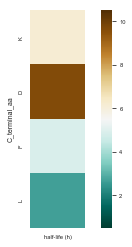

In [468]:
cmapName = "BrBG_r"
# vmax = 0.1
sns.heatmap(half_life.to_frame().loc[['K', 'D', 'F', 'L']], cmap=cmapName, vmin=vmin, vmax=vmax, square=True)
plt.savefig(outputPath / 'half_life_heatmap.png', dpi=400)

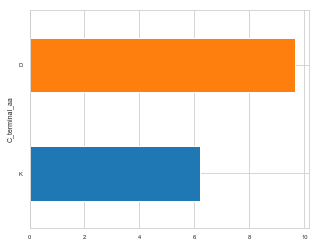

In [442]:
# sns.barplot(data=half_life, y=ylabel, order=aaOrder, ci=None)

fig, ax = plt.subplots(figsize=(5, 4))
half_life.loc[['K', 'D', ]].plot.barh(ax=ax)

In [373]:
for aa1 in ['D', 'K', 'NK']:
    for aa2 in ['L', 'WL']:
        print(aa2, "/", aa1, rateAvg.loc[aa2] / rateAvg.loc[aa1])

L / D 3.6264310979640446
WL / D 2.4372102357332803
L / K 2.3249729115660926
WL / K 1.5625411388769392
L / NK 2.643448084019358
WL / NK 1.776578281500658


In [376]:
lucTime0

,C-terminal amino acid(s),replicate,time (h),steady-state (time=0) normalized luminescence
0,K,1,0,1.637062
5,D,1,0,1.775668
10,L,1,0,0.701878
15,F,1,0,0.798229
20,P,1,0,1.000000
25,T,1,0,1.117811
30,WL,1,0,0.399086
35,NK,1,0,1.505090
40,K,2,0,1.235648
45,D,2,0,2.083347


In [380]:
lucTime0Avg = lucTime0.groupby('C-terminal amino acid(s)')['steady-state (time=0)\nnormalized luminescence'].mean()
lucTime0Avg

C-terminal amino acid(s)
D     2.039576
F     0.801224
K     1.486342
L     0.695211
NK    1.377033
P     1.000000
T     0.871206
WL    0.400661
Name: steady-state (time=0)\nnormalized luminescence, dtype: float64

In [381]:
steadyStateDf = lucTime0Avg.to_frame().join(rateAvg)
steadyStateDf

,steady-state (time=0) normalized luminescence,degradation_rate
C-terminal amino acid(s),,
D,2.039576,0.071671
F,0.801224,0.141988
K,1.486342,0.111791
L,0.695211,0.259911
NK,1.377033,0.098323
P,1.000000,0.155511
T,0.871206,0.150956
WL,0.400661,0.174678


In [382]:
ylabel = 'relative synthesis rate (h$^{-1}$)'

In [383]:
synthesisAvg = lucTime0Avg * rateAvg
synthesisAvg.name = ylabel
synthesisAvg = synthesisAvg / synthesisAvg.loc['P']
synthesisAvg

C-terminal amino acid(s)
D     0.939990
F     0.731553
K     1.068473
L     1.161929
NK    0.870636
P     1.000000
T     0.845690
WL    0.450043
Name: relative synthesis rate (h$^{-1}$), dtype: float64

In [384]:
x = 'C-terminal amino acid(s)'
plotDf5 = synthesisAvg.to_frame().reset_index()
plotDf5

,C-terminal amino acid(s),relative synthesis rate (h$^{-1}$)
0,D,0.939990
1,F,0.731553
2,K,1.068473
3,L,1.161929
4,NK,0.870636
5,P,1.000000
6,T,0.845690
7,WL,0.450043


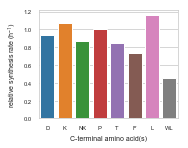

In [292]:
fig, ax = plt.subplots(figsize=(2.5, 2))
sns.barplot(ax=ax, data=plotDf5, x=x, y=ylabel, order=aaOrder)

# add_stat_annotation(ax=ax, plot='barplot', data=plotDf2, x=x, y=ylabel, order=aaOrder,
#                     box_pairs=box_pairs,
#                     test='t-test_ind', text_format='star', loc='inside')
fig.savefig(outputPath / 'relative_synthesis_rate.png')
fig.savefig(outputPath / 'relative_synthesis_rate.png', dpi=300)

In [385]:
steadyStateDf

,steady-state (time=0) normalized luminescence,degradation_rate
C-terminal amino acid(s),,
D,2.039576,0.071671
F,0.801224,0.141988
K,1.486342,0.111791
L,0.695211,0.259911
NK,1.377033,0.098323
P,1.000000,0.155511
T,0.871206,0.150956
WL,0.400661,0.174678


In [387]:
aaOrder

['D', 'K', 'NK', 'P', 'T', 'F', 'L', 'WL']

In [397]:
xlabel = '1/degradation rate (h)'
ylabel = 'steady-state (time=0)\nnormalized luminescence'
steadyStateDf[xlabel] = 1./steadyStateDf.iloc[:, 1]
xdata = steadyStateDf[xlabel].loc[aaOrder]
ydata = steadyStateDf[ylabel].loc[aaOrder]

verbose = 2
# Fitting the data with linear regression, no bounds on parameters,
# using statsmodel least squares
weights = None
sigmaWeighted = False

xdata = sm.add_constant(xdata)
result = sm.OLS(ydata, xdata).fit()
if verbose >= 2:
    print((result.params, result.rsquared))
    print(result.pvalues[1])
    print(result.summary())
    print(result.bse)

paramD = result.params[1]
paramIntercept = result.params[0]
# paramIntercept = 0
stdDevD = result.bse[1]
stdDevIntercept = result.bse[0]
stdDevIntercept = np.nan
covMatrix = result.cov_params()
r_squared = result.rsquared

fit = {'rate':paramD, 'intercept':paramIntercept, 'rate_std':stdDevD, 'intercept_std':stdDevIntercept,
        'R-squared':r_squared}
fit

(const                    -0.125522
1/degradation rate (h)    0.154219
dtype: float64, 0.8527831325718791)
0.0010575287638068555
                                          OLS Regression Results                                         
Dep. Variable:     steady-state (time=0)
normalized luminescence   R-squared:                       0.853
Model:                                                       OLS   Adj. R-squared:                  0.828
Method:                                            Least Squares   F-statistic:                     34.76
Date:                                           Wed, 05 Feb 2020   Prob (F-statistic):            0.00106
Time:                                                   11:25:19   Log-Likelihood:                 2.0386
No. Observations:                                              8   AIC:                          -0.07712
Df Residuals:                                                  6   BIC:                           0.08177
Df Model:              

/home/mweber/.local/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))


{'rate': 0.1542185305148467,
 'intercept': -0.12552207231596157,
 'rate_std': 0.026158956802036188,
 'intercept_std': nan,
 'R-squared': 0.8527831325718791}

In [398]:
ylabel

'steady-state (time=0)\nnormalized luminescence'

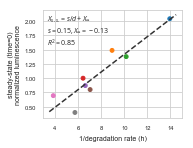

In [404]:
fig, ax = plt.subplots(figsize=(2.5, 2))

ax.scatter(steadyStateDf[xlabel].loc[aaOrder],
           steadyStateDf[ylabel].loc[aaOrder], c=sns.color_palette()[:len(steadyStateDf)],
           s=15)
a = fit['rate']
y0 = fit['intercept']
xmin, xmax = 3.5, 14.5
ax.plot([xmin, xmax], [y0 + a*xmin, y0 + a*xmax], c='0.2', ls='--')

ax.set_xlabel(xlabel)
ax.set_ylabel('steady-state (time=0)\nnormalized luminescence')

ax.annotate('$X_{{s.s.}} = s / d + X_{{\infty}}$\n$s = {:.2f}, X_{{\infty}} = {:.2f}$\n$R^2 = {:.2f}$'
            .format(fit['rate'], fit['intercept'], fit['R-squared']),
            xy=(0.03, 0.97), xycoords='axes fraction', ha='left', va='top')

filename = 'steady_state_regression'
fig.savefig(outputPath / (filename + '.svg'))
fig.savefig(outputPath / (filename + '.png'), dpi=300, bbox_inches='tight')

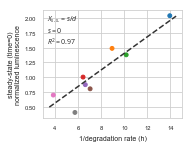

In [396]:
fig, ax = plt.subplots(figsize=(2.5, 2))

ax.scatter(steadyStateDf[xlabel].loc[aaOrder],
           steadyStateDf[ylabel].loc[aaOrder], c=sns.color_palette()[:len(steadyStateDf)],
           s=15)
a = fit['rate']
y0 = fit['intercept']
xmin, xmax = 3.5, 14.5
ax.plot([xmin, xmax], [y0 + a*xmin, y0 + a*xmax], c='0.2', ls='--')

ax.set_xlabel(xlabel)
ax.set_ylabel('steady-state (time=0)\nnormalized luminescence')

ax.annotate('$X_{{s.s.}} = s / d$\n$s = 0.$\n$R^2 = {:.2f}$'.format(fit['R-squared']),
            xy=(0.03, 0.97), xycoords='axes fraction', ha='left', va='top')

filename = 'steady_state_regression'
# fig.savefig(outputPath / (filename + '.svg'))
# fig.savefig(outputPath / (filename + '.png'), dpi=300, bbox_inches='tight')